_Note: To execute code in this repository, you will need to install the `niwaves` package from GitHub:_

https://github.com/rciric/niwaves

# Lagged correlation analysis with `niwaves`

#### Rastko Ciric<sup>1</sup>

<sup>1</sup>, Department of Bioengineering, Stanford University

The human brain is a complex, ordered network of neural cells. This network transforms, routes, and integrates signals generated by environmental stimuli in order to produce behavioural patterns. Although tools for directly investigating neural networks at a fine spatial scale are generally invasive and unsuitable for human populations, functional magnetic resonance imaging (fMRI) allows scientists to noninvasively probe the shape of the neural network by measuring oxygenation in the vascular network that provides the brain with its energy needs. This vascular network is coupled to the neural network by way of the haemodynamic response: localised increases in neural population spiking require elevated energy input, which necessitates increased blood supply to the active tissue. This increased blood supply is measurable as a stereotyped haemodynamic response. Because haemodynamic processes occur at slower time scales than do neural processes, some temporal information about neural processes is lost in fMRI.

However, fMRI remains a useful tool for mapping dynamics on the connectome. This is possible by estimating the synchrony between locally measured signals in different parts of the brain: if a set of regions consistently tend to co-activate temporally, their co-activation can be interpreted as evidence of a direct or indirect functional association between those regions. The preponderance of studies of functional brain connectivity evaluate _zero-lagged_ connectivity: they measure the instantaneous synchrony among a set of brain regions. However, signals do not instantaneously propagate across the brain. Instead, there must be some latency between activation in a presynaptic cell population and activation in a postsynaptic cell population. This latency occurs on the millisecond time scale, well below the temporal resolution of typical fMRI studies. However, by means of interpolating between fMRI observations, it might be possible to infer with some modicum of accuracy the fractional latency between brain regions.

A recent corpus of work<sup>1,2</sup> has implemented _lagged correlation analysis_ as a step toward neural signal propagation inference. Like conventional analyses of functional connectivity, lagged correlation analysis estimates the synchrony between pairs of brain regions. However, lagged correlation analysis additionally temporally shifts one time series with respect to the other in single-T<sub>R</sub> increments and estimates the lagged synchrony between these time series at each T<sub>R</sub> offset. Next, the temporal lag at which synchrony reaches a maximum is identified. Finally, to support fractional lag estimation, a parabolic curve is fit through the lag maximum and its immediate neighbours. The vertex of this parabola operationalises the temporal latency (abscissa) and peak correlation (ordinate) between each pair of regional time series.

Here, I have re-implemented lagged correlation analysis as the Python library `niwaves`. In this first section, I will demonstrate some basic features of lag analysis and potential artefactual processes that influence lagged correlation estimates.

In [24]:
import niwaves
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce

### Sample characteristics

We begin with a naive analysis of lagged connectivity, as defined by Mitra and colleagues. For this initial analysis, we will use a single subject's preprocessed data<sup>3</sup> with three tasks (rest, emotional identification, and n-back working memory).

* Repetition time/sampling time is 3 s.
* Data have been processed using a 36-parameter denoising model<sup>4</sup>.
* Mean time series have been extracted from each node of the 400-region version of the Schaefer parcellation<sup>5</sup>.
* A well-characterised 7-network community structure is used to sort the data<sup>6</sup>.
* Data comprise three tasks that have been concatenated temporally: rest, fractal n-back, and emotional identification (IDEMO).
* To run lag analysis for each task in turn, we use the `lag_analysis` function in `niwaves`, providing as an argument a temporal mask indicating whether each time point belongs to the task in question.

Begin by loading the dataset, all masks, and the 7-network community partition.

In [2]:
ts_bold = pd.read_table('data/PNC/sub-001_concatenatedBOLDts.1D', header=None, sep=' ')
mask_rest = pd.read_table('data/PNC/idx_rest.1D', header=None)
mask_nback = pd.read_table('data/PNC/idx_nback.1D', header=None)
mask_idemo = pd.read_table('data/PNC/idx_idemo.1D', header=None)
community = pd.read_table('data/network/schaefer400x7CommunityAffiliation.1D', header=None)

Next, execute lag analysis.

In [3]:
# Rest
lags_rest, peaks_rest = niwaves.lag_analysis(timeseries1=ts_bold.values,
                                             tmask=mask_rest.values,
                                             sample_time=3,
                                             min_block=15,
                                             lagmax=2)
# N-back
lags_nback, peaks_nback = niwaves.lag_analysis(timeseries1=ts_bold.values,
                                               tmask=mask_nback.values,
                                               sample_time=3,
                                               min_block=15,
                                               lagmax=2)
# IDEMO
lags_idemo, peaks_idemo = niwaves.lag_analysis(timeseries1=ts_bold.values,
                                               tmask=mask_idemo.values,
                                               sample_time=3,
                                               min_block=15,
                                               lagmax=2)

### Lag structure: a first look

Next, let's visualise the lag structure across the three different tasks. From top to bottom, the below plots summarise the lag structure of this subject's functional connectome during resting, n-back, and emotional identification tasks.

The below code reorganises the lag matrices first according to community structure and second according to mean nodal latencies within each community: "earlier" nodes are sorted to the left of "later" nodes. The relatively lower overall latencies along the diagonal correspond to within-community edges. Note that lag matrices are antisymmetric: if node A _leads_ node B by 0.3 s, then node B _lags_ node A by 0.3 s. In the lag matrix, a lead is encoded as a negative value (blue), while a lag is encoded as positive (red). By default, the colourmap ranges from -1.5 s to 1.5 s. (Due to a recent change in the code, the temporal scale and plot titles aren't currently plotted -- this will be updated soon.)

The distributions of lag values are also plotted to the right of the lag matrices. Because lag matrices are antisymmetric, these distributions will of necessity be symmetric around the origin. Notably, these distributions are fundamentally multimodal, with a separate distribution mode centred at each integral TR multiple (in this case, -3 s, 0 s, and +3 s).

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


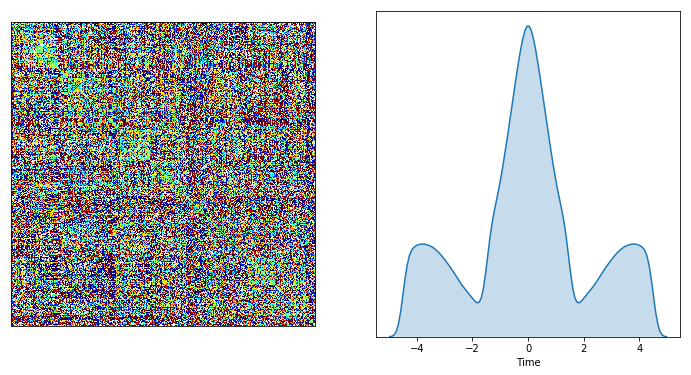

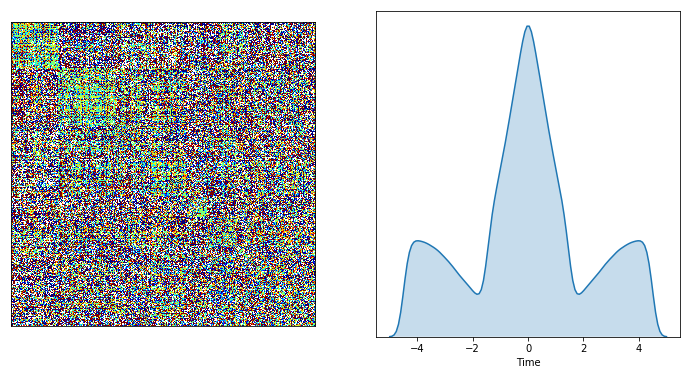

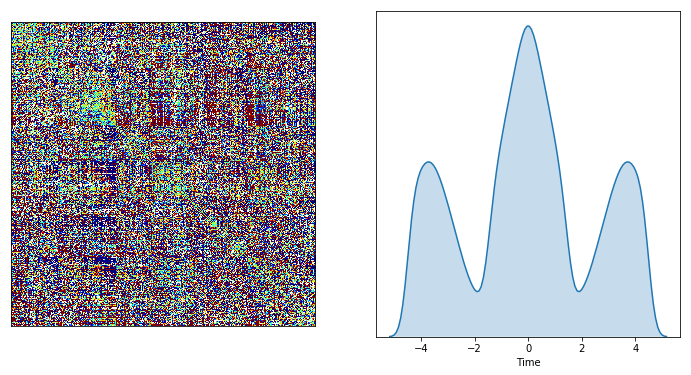

In [4]:
niwaves.lag_sort(lags_rest, community=community)
niwaves.lag_sort(lags_nback, community=community)
niwaves.lag_sort(lags_idemo, community=community)

Those are some noisy matrices! With a few hundred frames of data at best, the lag matrices don't appear to have much meaningful structure. Although within-community latencies (near the diagonal) generally appear to be shorter in duration than between-community latencies, it's hard to discern any further structure.

One result, however, looks interesting and immediately stands out -- the emotional identification matrix (bottom) has, on the whole, more lags clustered around the peaks at -3 s and +3 s than do the resting (top) or n-back (middle) matrices. Could this be attributable to task-related differences?

In this case, the answer is almost certainly not. Instead, these differences are more likely attributable to sampling variability. Let's take a look at the temporal masks that we used for each task. In the temporal mask visualisations, yellow indicates frames that are included in the lag estimation, while blue indicates frames that are omitted (in this case, because the subject is performing another task during those frames).

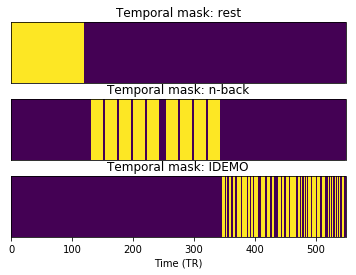

In [5]:
plt.subplot(3,1,1)
plt.imshow(mask_rest.values.T, aspect=100)
plt.title('Temporal mask: rest')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.subplot(3,1,2)
plt.imshow(mask_nback.values.T, aspect=100)
plt.title('Temporal mask: n-back')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.subplot(3,1,3)
plt.imshow(mask_idemo.values.T, aspect=100)
plt.title('Temporal mask: IDEMO')
plt.tick_params(axis='y', left=False, labelleft=False)
plt.xlabel('Time (TR)');

Although a greater overall number of time points is sampled for the n-back and IDEMO cases than for the rest case, these temporal masks censor intervening rest epochs from each task. The design of lag analysis necessitates a minimum number of contiguous points in each epoch. (For example, it's not possible to run a lag-3 analysis with only 2 consecutive observations!) The n-back task, which has a block design, isn't as affected when intervening epochs are censored as is the event-related IDEMO task. Because the IDEMO task is cut up into event epochs that are shorter than the minimum duration required to perform lagged cross-correlation, many IDEMO epochs are excluded from the analysis altogether, resulting in a substantially lower amount of data.

Next, let's load in an alternative set of masks that doesn't censor the intervening rest epochs from each task.

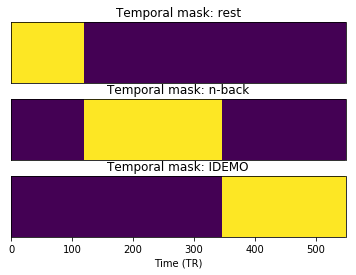

In [6]:
mask_nback_all = pd.read_table('data/PNC/idx_nback_all.1D', header=None)
mask_idemo_all = pd.read_table('data/PNC/idx_idemo_all.1D', header=None)

plt.subplot(3,1,1)
plt.imshow(mask_rest.values.T, aspect=100)
plt.title('Temporal mask: rest')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.subplot(3,1,2)
plt.imshow(mask_nback_all.values.T, aspect=100)
plt.title('Temporal mask: n-back')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.subplot(3,1,3)
plt.imshow(mask_idemo_all.values.T, aspect=100)
plt.title('Temporal mask: IDEMO')
plt.tick_params(axis='y', left=False, labelleft=False)
plt.xlabel('Time (TR)');

...and, repeating the analysis:

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


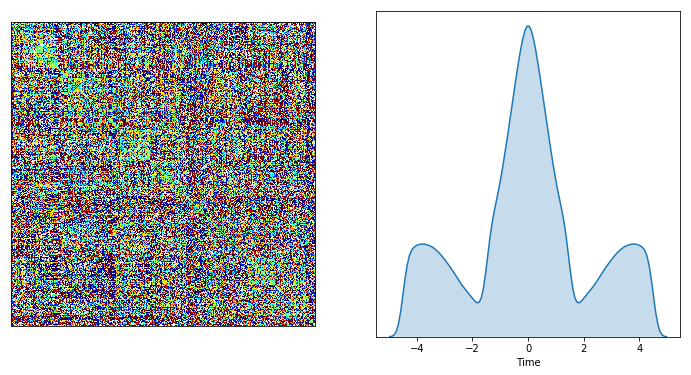

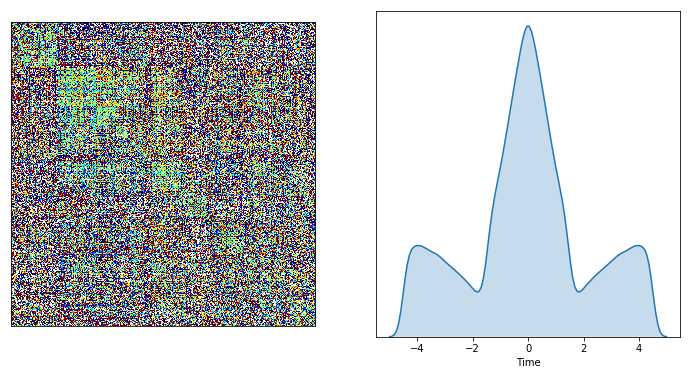

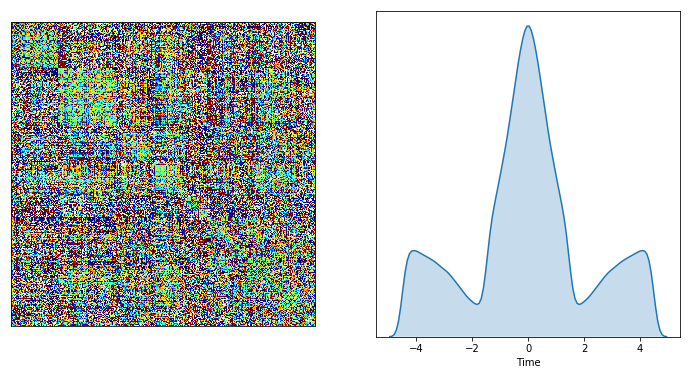

In [7]:
# Rest
lags_rest, peaks_rest = niwaves.lag_analysis(timeseries1=ts_bold.values,
                                             tmask=mask_rest.values,
                                             sample_time=3,
                                             min_block=15,
                                             lagmax=2)
# N-back
lags_nback, peaks_nback = niwaves.lag_analysis(timeseries1=ts_bold.values,
                                               tmask=mask_nback_all.values,
                                               sample_time=3,
                                               min_block=15,
                                               lagmax=2)
# IDEMO
lags_idemo, peaks_idemo = niwaves.lag_analysis(timeseries1=ts_bold.values,
                                               tmask=mask_idemo_all.values,
                                               sample_time=3,
                                               min_block=15,
                                               lagmax=2)

niwaves.lag_sort(lags_rest, community=community)
niwaves.lag_sort(lags_nback, community=community)
niwaves.lag_sort(lags_idemo, community=community)

As hypothesised, the most prominent difference in distributions vanishes after changing to a mask with better coverage. (Notably, other differences in the lag matrix structure appear; however, (i) there are additional confounds that we have yet to consider and (ii) this is a toy example with a sample size of 1 poorly sampled subject, so I strongly caution against lending weight to the differences observed here.) Together, this highlights a potential concern with the naive lag analysis: the analysis appears to be sensitive to data sampling.

### Sampling variability and lag estimates

Let's examine this a little bit more methodically. To do this, we'll use a highly sampled subject from the Midnight Scan Club dataset<sup>7</sup>, combining across 10 half-hour epochs. Beginning from this combined dataset (8140 frames, 5 hours of data), we generate a series of progressively longer temporal masks. The first temporal mask comprises only the first 20 frames of the time series. Next, the mask is expanded by an additional 20 frames, and a further 20 frames thereafter, and so on. We increment in this way until we cover most of the 5-hour combined time series.

For each progressively longer temporal mask, we plot the distribution of observed lags in the first plot below. Initially, for the 20-frame mask, the five peaks corresponding to the five T<sub>R</sub>s of interest are relatively even in size. However, as the number of observations is increased, the density of lags becomes increasingly concentrated around the central zero-lag peak. Notably, the addition of more observations appears to yield diminishing returns with respect to the observed distribution: after a point, the relative sizes of the different peaks becomes fairly stable.

To examine this further, we also compute the standard deviation of the lag distribution for each progressively longer temporal mask. The second plot below shows that, as the number of observations increases, the standard deviation of lag estimates drops -- to a point. Initially, this drop is precipitous; however, the drop turns into a slower decline or plateau after sufficiently many observations are included. It must be emphasised that this in no way suggests that the lag estimates themselves are stabilising: it indicates only that the _distribution_ of all lag estimates appears to converge toward a particular distribution shape.

(If we wanted to approach this more rigorously, we might resample many times for each masking increment instead of using only the first _n_ frames. Furthermore, rather than limiting our measure to simple variance, we might take inventory of network metrics of interest.)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Standard deviation')

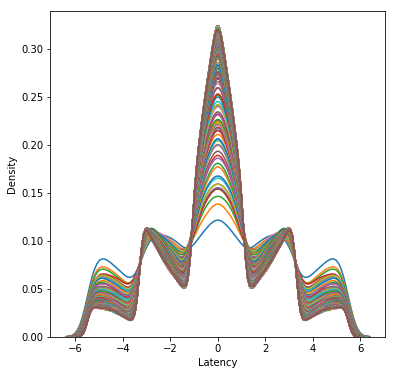

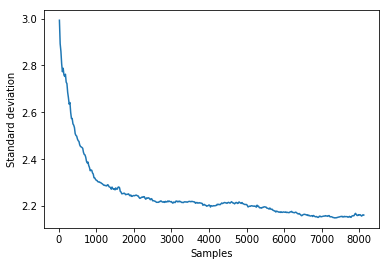

In [26]:
ts_msc = glob.glob('data/MSC/ts/sub-MSC01_ses-*_task-rest_run-01_schaefer400_ts.1D')
for i, ts in enumerate(ts_msc):
    ts_msc[i] = pd.read_csv(ts, sep=' ', header=None)
ts_msc = reduce(lambda x, y: pd.concat([x, y]), ts_msc)
tmask = np.zeros(ts_msc.shape[0])

plt.figure(figsize=(6,6))
var = []
for t in np.arange(20, ts_msc.shape[0], 20):
    tmask[0:t] = 1
    lags_msc, peaks_msc = niwaves.lag_analysis(timeseries1=ts_msc.values,
                                                           tmask=tmask,
                                                           sample_time=2.2,
                                                           min_block=10,
                                                           lagmax=3)
    var.append(np.nanstd(lags_msc.ravel()))
    sns.kdeplot(lags_msc.ravel(), ax=plt.gca())

plt.xlabel('Latency')
plt.ylabel('Density')
plt.figure()
plt.plot(np.arange(20, ts_msc.shape[0], 20), var)
plt.xlabel('Samples')
plt.ylabel('Standard deviation');

### Haemodynamic confounds

Data sampling isn't the only potential concern with lag analysis. Another potential (major) pitfall is the regional (and inter-individual) variability in the delay and shape of the haemodynamic response. To illustrate this, let's consider a system of two connected brain regions. Region *A* is presynaptic to region *B*. However, regions *A* and *B* receive blood supply from the same arterial system, which carries blood through *B* before it arrives at *A*. In this case, it's possible that region *B* will appear to lead region *A* haemodynamically although it lags region *A* neurally. This unfortunately doesn't appear to be a problem tractable to fMRI analysis, but Mitra and colleagues have demonstrated correspondence between infra-slow electrical (neural) signal propagation patterns and haemodynamic lag systems<sup>8</sup>.

### Epoch and binning effects

For now, let's close off our naive investigation and initial investigation of sampling error by ensuring that another type of sampling error -- due to subdivision of the time series into sub-epochs -- does not inordinately impact lag estimates. Typically, lagged correlation is computed separately for each contiguous temporal epoch. Next, the mean correlation is computed for each lag by weighting the contributions of each epoch by the number of observations in that epoch. Finally, optima are identified and parabolic interpolation is applied over the weighted mean correlations. It's possible that the same observations could result in substantially different lag estimates depending on the epoch in which they are included.

To evaluate the potential contribution of epoch binning artefacts, we bin a subject's time series into epochs of differing lengths (17 epochs of 31 frames, 9 epochs of 60 frames, 4 epochs of 120 frames, 2 epochs of 250 frames, and a single continuous epoch of 549 frames*) and evaluate whether there exist any systematic differences across the different binning strategies. Below, we plot the sorted lag matrices and lag distributions for each of the listed binning strategies in order from top to bottom.

`*` Remaining observations are included in an additional shorter epoch, so most of the same observations will be present across all measurements.

In [8]:
def ts_break(ts, interval):
    """Break up a time series into subsamples of a specified
    duration. Return the temporal mask that will restore the
    original time series.
    """
    num_intervals = ts.shape[0] // interval
    tmask = np.ones(ts.shape[0] + num_intervals, dtype='bool')
    ts_broken = np.zeros([ts.shape[0] + num_intervals, ts.shape[1]])
    for i in range(num_intervals):
        ts_broken[i*(interval+1):(i+1)*(interval+1)-1,:] = ts[i*(interval):(i+1)*interval,:]
        tmask[(i+1)*(interval+1)-1] = False
    ts_broken[(i+1)*(interval+1):,:] = ts[(i+1)*(interval):,:]
    return ts_broken, tmask

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


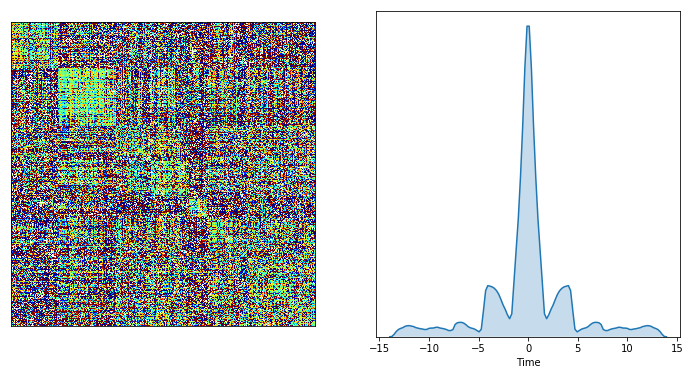

<Figure size 432x288 with 0 Axes>

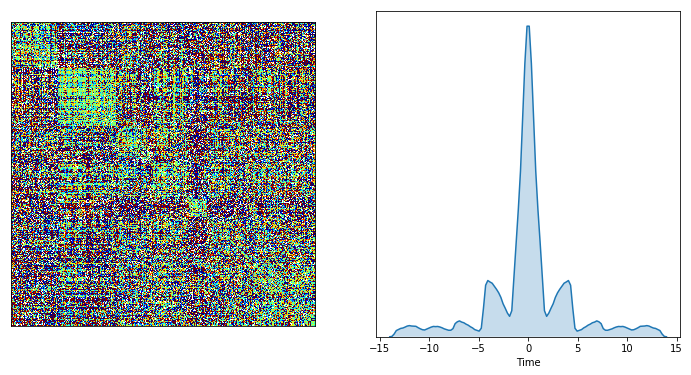

<Figure size 432x288 with 0 Axes>

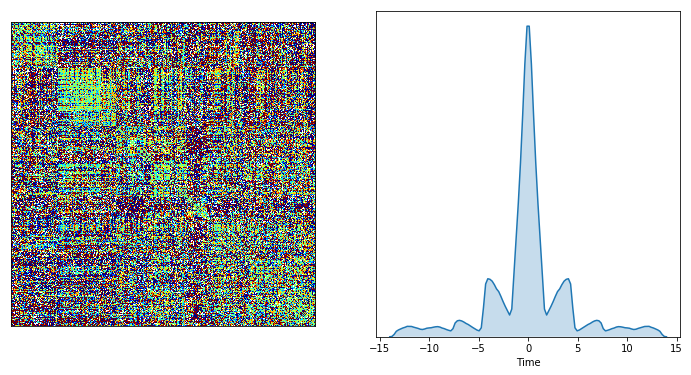

<Figure size 432x288 with 0 Axes>

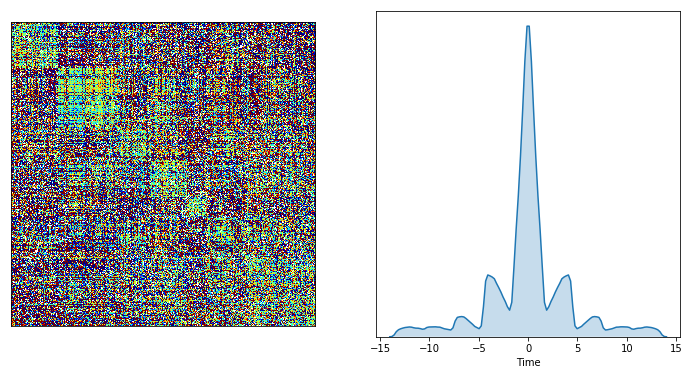

<Figure size 432x288 with 0 Axes>

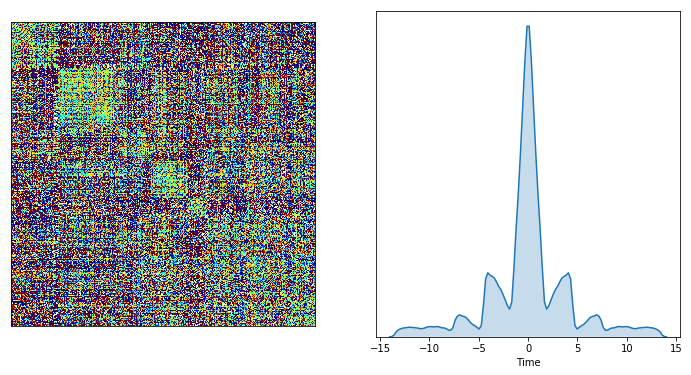

<Figure size 432x288 with 0 Axes>

In [10]:
for i in [31, 60, 120, 250, 549]:
    ts_broken, tmask = ts_break(ts_bold.values, i)
    lags, peaks = niwaves.lag_analysis(timeseries1=ts_broken,
                                       tmask=tmask,
                                       sample_time=3)
    niwaves.lag_sort(lags, community=community)

In this case, although the matrices differ, no systematic effect is readily apparent. Of course, this qualitative approach isn't really sufficient, and this possibility should probably be investigated more rigorously.

### References

1. Mitra A, Snyder AZ, Hacker CD, Raichle ME (2014) Lag structure in resting-state fMRI. J Neurophysiol 111(11):2374-91.

2. Mitra A, Snyder AZ, Blazey T, Raichle ME (2015) Lag threads organize the brain's intrinsic activity. Proc Natl Acad Sci U S A 112(17):E2235-44.

3. Satterthwaite TD, Connolly JJ, Ruparel K, Calkins ME, Jackson C, Elliott MA, Roalf DR, Ryan Hopson, Prabhakaran K, Behr M, Qiu H, Mentch FD, Chiavacci R, Sleiman PM, Gur RC, Hakonarson H, Gur RE (2016) The Philadelphia Neurodevelopmental Cohort: A publicly available resource for the study of normal and abnormal brain development in youth. Neuroimage 124(Pt B):1115-9.

4. Satterthwaite TD, Elliott MA, Gerraty RT, Ruparel K, Loughead J, Calkins ME, Eickhoff SB, Hakonarson H, Gur RC, Gur RE, Wolf DH (2013) An improved framework for confound regression and filtering for control of motion artifact in the preprocessing of resting-state functional connectivity data. Neuroimage 64:240-56.

5. Schaefer A, Kong R, Gordon EM, Laumann TO, Zuo XN, Holmes AJ, Eickhoff SB, Yeo BTT (2018) Local-Global Parcellation of the Human Cerebral Cortex from Intrinsic Functional Connectivity MRI. Cereb Cortex 28(9):3095-3114.

6. Yeo BT, Krienen FM, Sepulcre J, Sabuncu MR, Lashkari D, Hollinshead M, Roffman JL, Smoller JW, Zöllei L, Polimeni JR, Fischl B, Liu H, Buckner RL (2011) The organization of the human cerebral cortex estimated by intrinsic functional connectivity. J Neurophysiol 106(3):1125-65.

7. Gordon EM, Laumann TO, Gilmore AW, Newbold DJ, Greene DJ, Berg JJ, Ortega M, Hoyt-Drazen C, Gratton C, Sun H, Hampton JM, Coalson RS, Nguyen AL, McDermott KB, Shimony JS, Snyder AZ, Schlaggar BL, Petersen SE, Nelson SM, Dosenbach NUF (2017) Precision Functional Mapping of Individual Human Brains. Neuron 95(4):791-807.e7.

8. Mitra A, Kraft A, Wright P, Acland B, Snyder AZ, Rosenthal Z, Czerniewski L, Bauer A, Snyder L, Culver J, Lee JM, Raichle ME (2018) Spontaneous Infra-slow Brain Activity Has Unique Spatiotemporal Dynamics and Laminar Structure. Neuron 98(2):297-305.e6.